In [12]:
%matplotlib inline

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy import stats

FIGURE_PATH = '../figures/'
PNG_PATH = '../images/'
DATA_PATH = '../data/'

SIGNIFICANCE_LEVEL = 0.05

# 4 size metrics, 14 code metrics, 2 groups (perfective, corrective) 3 statistical tests (normality, MWU)
# 4 * 2 * 3 + 14 * 2 * 3 + 14 * 2 * 3
NUM_TESTS = 192 

THRESH = SIGNIFICANCE_LEVEL / NUM_TESTS

COLUMBUSQM_FEATURES = ['McCC_file', 'LLOC_file', 'CLOC_class_sum', 'CD_class_sum', 'AD_class_sum', 'ThrowStatement_file', 'node_count_file', 'MethodInvocation_file', 'MethodDeclaration_file','Minor', 'Major', 'Critical']

In [13]:
def ll_values(values):
    signs = np.sign(values)
    vals = np.log10(np.abs(values) + 1)
    return vals * signs

def cliffsd(u, n1, n2):
    d = (2*u) / (n1 * n2) - 1
    return abs(d)

def cd_name(cd):
    if cd < 0.1:
        return 'n'
    elif 0.1 <= cd < 0.33:
        return 's'
    elif 0.33 <= cd < 0.474:
        return 'm'
    elif 0.474 <= cd:
        return 'l'

def plot_parent_density(df, feature_names):
    for m in feature_names:
        col = 'parent_{}'.format(m)

        perf = ll_values(df[(df['internal_quality'] == True)][col].values)
        corr = ll_values(df[(df['external_quality'] == True)][col].values)

        fig = plt.figure(figsize=(3, 2.3))
        ax = fig.gca()

        dtf = pd.DataFrame()
        dtf['perf.'] = perf

        dtf2 = pd.DataFrame()
        dtf2['corr.'] = corr

        dtf.plot(kind='density', ax=ax)
        dtf2.plot(kind='density', ax=ax)
        ax.set_xlabel('log {} + 1'.format(m.split('_')[0]))
        plt.tight_layout()
        plt.savefig('{}/density_parent_{}.pdf'.format(FIGURE_PATH, m))
    
def print_boxes_size(df, save=False, predictions=False, only_changes=False):
    names = {'lines_added': '#lines added',
             'lines_deleted': '#lines deleted',
             'files_modified': '#files modified',
             'num_hunks': '#hunks'}

    for m in ['lines_added', 'lines_deleted', 'files_modified', 'num_hunks']:
        col = '{}'.format(m)

        a = df[(df[col] != 0)][col].values
        iq = df[(df[col] != 0) & (df['internal_quality'] == True)][col].values
        eq = df[(df[col] != 0) & (df['external_quality'] == True)][col].values

        if len(iq) < 3 or len(eq) < 3:
            print('skipping', m)
            continue

        fig = plt.figure(figsize=(3, 2.3))
        ax = fig.add_subplot(111)
        bp = ax.boxplot([a, iq, eq], showfliers=False, positions=[1, 1.5, 2])

        ax.set_xticklabels(['all', 'perf.', 'corr.'])
        ax.set_ylabel('{}'.format(names[m]))

        plt.tight_layout()
        
        if save:
            if predictions:
                m = '{}_predictions'.format(m)
            
            if only_changes:
                m = '{}_only_changes'.format(m)

            plt.savefig('{}/boxplot_{}.pdf'.format(FIGURE_PATH, m))
            plt.savefig('{}/boxplot_{}.png'.format(PNG_PATH, m))

def print_boxes_metrics(df, feature_names, density=False, predictions=False, only_changes=False):

    for m in feature_names:
        col = 'delta_{}'.format(m)

        a = ll_values(df[(df[col] != 0)][col].values)
        quali = ll_values(df[(df[col] != 0) & (df['internal_quality'] == True)][col].values)
        bugfix = ll_values(df[(df[col] != 0) & (df['external_quality'] == True)][col].values)

        if density:
            dcol = 'density_{}'.format(col)
            df[dcol] = df[col] / (df['lines_added'] + df['lines_deleted'] + 1)

            a = ll_values(df[(df[dcol] != 0)][dcol].values)
            quali = ll_values(df[(df[dcol] != 0) & (df['internal_quality'] == True)][dcol].values)
            bugfix = ll_values(df[(df[dcol] != 0) & (df['external_quality'] == True)][dcol].values)

        fig = plt.figure(figsize=(3, 2.3))
        ax = fig.add_subplot(111)
        bp = ax.boxplot([a, quali, bugfix], showfliers=False, positions=[1, 1.5, 2])

        ax.set_xticklabels(['all', 'perf.', 'corr.'])
        ax.set_ylabel('log {} delta + 1'.format(m.split('_')[0]))
        ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))

        plt.tight_layout()
        if density:
            m = '{}_density'.format(m)
        if predictions:
            m = '{}_predictions'.format(m)
        if only_changes:
            m = '{}_only_changes'.format(m)

        plt.savefig('{}/boxplot_{}.pdf'.format(FIGURE_PATH, m))
        plt.savefig('{}/boxplot_{}.png'.format(PNG_PATH, m))

def print_tables_metrics(df, feature_names, density=False, thresh=0.05):
    tbl = ''

    # alternative hypothesis for MWU, we expect these to be lower for all quality improving changes (H0), therfore alternative (H1) is greater
    greater = ['McCC_file', 'LLOC_file', 'ThrowStatement_file', 'node_count_file', 'MethodInvocation_file', 'MethodDeclaration_file', 'Minor', 'Major', 'Critical']

    # we expect these to be greater, therefore alternative is lower
    less = ['CLOC_class_sum', 'CD_class_sum', 'AD_class_sum']

    features = ['delta_{}'.format(m) for m in feature_names]
    for f in features:
        df['scaled_{}'.format(f)] = np.copy(df[f].values)
        df['density_{}'.format(f)] = df[f] / (df['lines_added'] + df['lines_deleted'] + 1)

    for m in feature_names:
        col = 'delta_{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values

        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        if density:
            quali = df[(df['internal_quality'] == True)]['density_' + col].values
            no_quali = df[(df['internal_quality'] == False)]['density_' + col].values
            
            bugfix = df[(df['external_quality'] == True)]['density_' + col].values
            no_bugfix = df[(df['external_quality'] == False)]['density_' + col].values

        try:
            alternative = 'greater'
            if col in less:
                alternative = 'less'

            #print(col)
            #print('quali', stats.shapiro(quali))
            #print('no_quali', stats.shapiro(no_quali))
            #print('bugfix', stats.shapiro(bugfix))
            #print('no_bugfix', stats.shapiro(no_bugfix))
            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative=alternative)
            qe = '-'
            
            p1 = '{:.4f}'.format(mwu_p)
            if mwu_p < 0.0001:
                p1 = r'\textless0.0001'

            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'

            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative=alternative)            
            bfe = '-'
            
            p2 = '{:.4f}'.format(mwu_p2)
            if mwu_p2 < 0.0001:
                p2 = r'\textless0.0001'

            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'

            tbl += r'{} & {} & {} & {} & {}\\'.format(m.split('_')[0], 
                                                                        p1, qe, 
                                                                        p2, bfe) + "\n"
        except ValueError as e:
            print(e)
            tbl += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{2}{c}{-}' + ' & ' + r'\multicolumn{2}{c}{-}\\' + "\n"
            pass
    print(tbl)
    
def print_detailed_tables_metrics(df, feature_names, density=False, thresh=0.05, normality='anderson'):
    tbl_corrective = ''
    tbl_perfective = ''

    # alternative hypothesis for MWU, we expect these to be lower for all quality improving changes (H0), therfore alternative (H1) is greater
    greater = ['McCC_file', 'LLOC_file', 'ThrowStatement_file', 'node_count_file', 'MethodInvocation_file', 'MethodDeclaration_file', 'Minor', 'Major', 'Critical']

    # we expect these to be greater, therefore alternative is lower
    less = ['CLOC_class_sum', 'CD_class_sum', 'AD_class_sum']

    features = ['delta_{}'.format(m) for m in feature_names]
    for f in features:
        df['scaled_{}'.format(f)] = np.copy(df[f].values)
        df['density_{}'.format(f)] = df[f] / (df['lines_added'] + df['lines_deleted'] + 1)

    for m in feature_names:
        col = 'delta_{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values

        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        if density:
            quali = df[(df['internal_quality'] == True)]['density_' + col].values
            no_quali = df[(df['internal_quality'] == False)]['density_' + col].values
            
            bugfix = df[(df['external_quality'] == True)]['density_' + col].values
            no_bugfix = df[(df['external_quality'] == False)]['density_' + col].values

        try:
            alternative = 'greater'
            if col in less:
                alternative = 'less'

            #print(col)
            #print('quali', stats.shapiro(quali))
            #print('no_quali', stats.shapiro(no_quali))
            #print('bugfix', stats.shapiro(bugfix))
            #print('no_bugfix', stats.shapiro(no_bugfix))
            if normality == 'anderson':
                ad1 = stats.anderson(no_quali, dist='norm')
                ad2 = stats.anderson(quali, dist='norm')
                ad3 = stats.anderson(no_bugfix, dist='norm')
                ad4 = stats.anderson(bugfix, dist='norm')

                # if the test statistic is larger than the critical value for the chosen alpha it means that the observed distribution is significantly different from the normal distribution
                ad1_is_significant = ad1.statistic > ad1.critical_values[list(ad1.significance_level).index(1.)]
                ad2_is_significant = ad1.statistic > ad1.critical_values[list(ad2.significance_level).index(1.)]
                ad3_is_significant = ad1.statistic > ad1.critical_values[list(ad3.significance_level).index(1.)]
                ad4_is_significant = ad1.statistic > ad1.critical_values[list(ad4.significance_level).index(1.)]
            
            if normality == 'shapiro':
                sha1, sha_p1 = stats.shapiro(no_quali)
                sha2, sha_p2 = stats.shapiro(quali)
                sha3, sha_p3 = stats.shapiro(no_bugfix)
                sha4, sha_p4 = stats.shapiro(bugfix)

            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative=alternative)
            qe = '-'
            
            p1 = '{:.4f}'.format(mwu_p)
            if mwu_p < 0.0001:
                p1 = r'\textless0.0001'

            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'

            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative=alternative)            
            bfe = '-'
            
            p2 = '{:.4f}'.format(mwu_p2)
            if mwu_p2 < 0.0001:
                p2 = r'\textless0.0001'

            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'
                
            m_no_quali = np.median(no_quali)
            m_quali = np.median(quali)
            m_no_bugfix = np.median(no_bugfix)
            m_bugfix = np.median(bugfix)
            
            if m_no_quali < 0.01 and m_no_quali != 0:
                m_no_quali = r'\textless0.01'
            else:
                m_no_quali = '{:.2f}'.format(m_no_quali)
            if m_quali < 0.01 and m_quali != 0:
                m_quali = r'\textless0.01'
            else:
                m_quali = '{:.2f}'.format(m_quali)
            if m_no_bugfix < 0.01 and m_no_bugfix != 0:
                m_no_bugfix = r'\textless0.01'
            else:
                m_no_bugfix = '{:.2f}'.format(m_no_bugfix)
            if m_bugfix < 0.01 and m_bugfix != 0:
                m_bugfix = r'\textless0.01'
            else:
                m_bugfix = '{:.2f}'.format(m_bugfix)

            if normality == 'anderson':
                tbl_perfective += r'{} & {} & {} & {} & {},{} & {},{} & {},{}\\'.format(m.split('_')[0], 
                                                                            p1, qe, mwu,
                                                                            m_no_quali, m_quali,
                                                                            len(no_quali), len(quali),
                                                                            ad1_is_significant, ad2_is_significant,
                                                                            ) + "\n"
                tbl_corrective += r'{} & {} & {} & {} & {},{} & {},{} & {},{}\\'.format(m.split('_')[0], 
                                                                            p2, bfe, mwu2,
                                                                            m_no_bugfix, m_bugfix,
                                                                            len(no_bugfix), len(bugfix),
                                                                            ad3_is_significant, ad4_is_significant,
                                                                            ) + "\n"
            if normality == 'shapiro':
                if sha_p1 < thresh:
                    sha_p1 = r'\textbf{' + r'\textless0.0001' + r'}'
                if sha_p2 < thresh:
                    sha_p2 = r'\textbf{' + r'\textless0.0001' + r'}'
                if sha_p3 < thresh:
                    sha_p3 = r'\textbf{' + r'\textless0.0001' + r'}'
                if sha_p4 < thresh:
                    sha_p4 = r'\textbf{' + r'\textless0.0001' + r'}'
                tbl_perfective += r'{} & {} & {} & {} & {},{} & {},{} & {:.2f},{:.2f} & {},{}\\'.format(m.split('_')[0], 
                                                                            p1, qe, mwu,
                                                                            m_no_quali, m_quali,
                                                                            len(no_quali), len(quali),
                                                                            sha1, sha2,
                                                                            sha_p1, sha_p2,
                                                                            ) + "\n"
                tbl_corrective += r'{} & {} & {} & {} & {},{} & {},{} & {:.2f},{:.2f} & {},{}\\'.format(m.split('_')[0],                                    
                                                                            p2, bfe, mwu2,
                                                                            m_no_bugfix, m_bugfix,
                                                                            len(no_bugfix), len(bugfix),
                                                                            sha3, sha3,
                                                                            sha_p3, sha_p4,
                                                                            ) + "\n"
        except ValueError as e:
            print(e)
            if normality == 'anderson':
                tbl_perfective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{6}{c}{-}\\' + "\n"
                tpl_corrective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{6}{c}{-}\\' + "\n"
            if normality == 'shapiro':
                tbl_perfective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{7}{c}{-}\\' + "\n"
                tpl_corrective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{7}{c}{-}\\' + "\n"
            pass
    if normality == 'shapiro':
        print('Perfective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & SHA Statistic & SHA p-val\\')
        print(tbl_perfective)
        print('---')
        print('Corrective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & SHA Statistic & SHA p-val\\')
        print(tbl_corrective)
    if normality == 'anderson':
        print('Perfective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & Non-normality\\')
        print(tbl_perfective)
        print('---')
        print('Corrective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & Non-normality\\')
        print(tbl_corrective)

def print_tables_size(df, thresh=0.05):
    tbl = ''
    names = {'lines_added': '\#lines add',
             'lines_deleted': '\#lines del',
             'files_modified': '\#files mod',
             'num_hunks': '\#hunks'}
    for m in ['lines_added', 'lines_deleted', 'files_modified', 'num_hunks']:
        col = '{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values
        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        try:
            #print(col)
            #print('quali', stats.shapiro(quali))
            #print('no_quali', stats.shapiro(no_quali))
            #print('bugfix', stats.shapiro(bugfix))
            #print('no_bugfix', stats.shapiro(no_bugfix))
            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative='two-sided')
            qe = '-'
            p1 = '{:.4f}'.format(mwu_p)
            if mwu_p < 0.0001:
                p1 = r'\textless0.0001'
            
            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'
            
            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative='two-sided')
            bfe = '-'
            p2 = '{:.4f}'.format(mwu_p2)

            if mwu_p2 < 0.0001:
                p2 = r'\textless0.0001'

            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'
            
            #tbl += r'{} & {} & {} & {} & {} & {} & {}\\'.format(names[m], np.median(no_quali) - np.median(quali), p1, qe, np.median(no_bugfix) - np.median(bugfix), p2, bfe) + "\n"
            tbl += r'{} & {} & {} & {} & {}\\'.format(names[m], p1, qe, p2, bfe) + "\n"
        except ValueError as e:
            print(e)
            #tbl += r'{} & '.format(m) + r'\multicolumn{3}{c}{-}' + ' & ' + r'\multicolumn{3}{c}{-}\\' + "\n"
            tbl += r'{} & '.format(m) + r'\multicolumn{2}{c}{-}' + ' & ' + r'\multicolumn{2}{c}{-}\\' + "\n"
            pass
    print(tbl)

def print_nz_table(df, feature_names):
    """for each metric, number of non zero values, non zero perfective, non zero corrective"""
    tbl = ''
    for m in feature_names:
        col = 'delta_{}'.format(m)

        num = len(df)
        num_nz = len(df[(df[col] != 0)])
        
        num_quali = len(df[(df['internal_quality'] == True)][col])
        num_bugfix = len(df[(df['external_quality'] == True)][col])

        num_nz_quali = len(df[(df[col] != 0) & (df['internal_quality'] == True)][col])
        num_nz_bugfix = len(df[(df[col] != 0) & (df['external_quality'] == True)][col])
        
        tbl += r'{} & {:.2f} & {:.2f} & {:.2f}\\'.format(m.split('_')[0], (num_nz * 100) / num, (num_nz_quali * 100) / num_quali, (num_nz_bugfix * 100) / num_bugfix) + "\n"

    print(tbl)
    
# how were the files before the change?
def parent_files(df, features, save=False, predictions=False):
    table = ''
    for metric in features:
        delta = 'delta_' + metric
        df['fp_{}'.format(metric)] = df['parent_{}'.format(metric)] / df['files_modified']
        df['fc_{}'.format(metric)] = df['current_{}'.format(metric)] / df['files_modified']

        for m in ['fp_{}'.format(metric)]:  #, 'current_{}'.format(metric)]:
            
            a = df[m].values
            perf = df[(df['internal_quality'] == True)][m].values
            corr = df[(df['external_quality'] == True)][m].values

            fig = plt.figure(figsize=(3, 2.3))
            ax = fig.add_subplot(111)
            bp = ax.boxplot([a, perf, corr], showfliers=False, positions=[1, 1.5, 2])

            ax.set_xticklabels(['all', 'perf.', 'corr.'])
            ax.set_ylabel(r'$\sum ' + str('_'.join(m.split('_')[1:]).split('_')[0]) +  r'/changed files$')
            plt.tight_layout()
        
            if save:
                if predictions:
                    m = '{}_predictions'.format(m)
                plt.savefig('{}/boxplot_parent_{}.pdf'.format(FIGURE_PATH, m))
                plt.savefig('{}/boxplot_parent_{}.png'.format(PNG_PATH, m))

            # plt.show()
            table += r'{} & {:.2f} & {:.2f} & {:.2f}\\'.format(m.replace('fp_', '').split('_')[0], np.median(a), np.median(perf), np.median(corr)) + '\n'
            # print(m, 'median, all:', np.median(a), 'perfective:', np.median(perf), 'corrective:', np.median(corr))
            #print(m, 'avg, all:', np.mean(a), 'perfective:', np.mean(perf), 'corrective:', np.mean(corr))
    print(table)
    
def print_tables_parents(df, feature_names, thresh=0.05):
    tbl = ''

    for m in feature_names:
        col = 'parent_{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values

        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        try:
            # alternative is two-sided, we have no expectations
            alternative = 'two-sided'

            #print(col)
            #print('quali', stats.shapiro(quali))
            #print('no_quali', stats.shapiro(no_quali))
            #print('bugfix', stats.shapiro(bugfix))
            #print('no_bugfix', stats.shapiro(no_bugfix)
            
            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative=alternative)
            qe = '-'
            
            p1 = '{:.4f}'.format(mwu_p)
            if mwu_p < 0.0001:
                p1 = r'\textless0.0001'

            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'

            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative=alternative)            
            bfe = '-'
            
            p2 = '{:.4f}'.format(mwu_p2)
            if mwu_p2 < 0.0001:
                p2 = r'\textless0.0001'

            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'

            tbl += r'{} & {} & {} & {} & {}\\'.format(m.split('_')[0], 
                                                                        p1, qe, 
                                                                        p2, bfe) + "\n"
        except ValueError as e:
            print(e)
            tbl += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{2}{c}{-}' + ' & ' + r'\multicolumn{2}{c}{-}\\' + "\n"
            pass
    print(tbl)
    
def print_detailed_tables_parents(df, feature_names, thresh=0.05, normality='anderson'):
    tbl_corrective = ''
    tbl_perfective = ''

    for m in feature_names:
        col = 'parent_{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values

        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        try:
            # alternative is two-sided, we have no expectations
            alternative = 'two-sided'

            if normality == 'anderson':
                ad1 = stats.anderson(no_quali, dist='norm')
                ad2 = stats.anderson(quali, dist='norm')
                ad3 = stats.anderson(no_bugfix, dist='norm')
                ad4 = stats.anderson(bugfix, dist='norm')

                # if the test statistic is larger than the critical value for the chosen alpha it means that the observed distribution is significantly different from the normal distribution
                ad1_is_significant = ad1.statistic > ad1.critical_values[list(ad1.significance_level).index(1.)]
                ad2_is_significant = ad1.statistic > ad1.critical_values[list(ad2.significance_level).index(1.)]
                ad3_is_significant = ad1.statistic > ad1.critical_values[list(ad3.significance_level).index(1.)]
                ad4_is_significant = ad1.statistic > ad1.critical_values[list(ad4.significance_level).index(1.)]
            
            if normality == 'shapiro':
                sha1, sha_p1 = stats.shapiro(no_quali)
                sha2, sha_p2 = stats.shapiro(quali)
                sha3, sha_p3 = stats.shapiro(no_bugfix)
                sha4, sha_p4 = stats.shapiro(bugfix)

            m_no_quali = np.median(no_quali)
            m_quali = np.median(quali)
            m_no_bugfix = np.median(no_bugfix)
            m_bugfix = np.median(bugfix)
            
            if m_no_quali < 0.01 and m_no_quali != 0:
                m_no_quali = r'\textless0.01'
            else:
                m_no_quali = '{:.2f}'.format(m_no_quali)
            if m_quali < 0.01 and m_quali != 0:
                m_quali = r'\textless0.01'
            else:
                m_quali = '{:.2f}'.format(m_quali)
            if m_no_bugfix < 0.01 and m_no_bugfix != 0:
                m_no_bugfix = r'\textless0.01'
            else:
                m_no_bugfix = '{:.2f}'.format(m_no_bugfix)
            if m_bugfix < 0.01 and m_bugfix != 0:
                m_bugfix = r'\textless0.01'
            else:
                m_bugfix = '{:.2f}'.format(m_bugfix)

            #print(col)
            #print('quali', stats.shapiro(quali))
            #print('no_quali', stats.shapiro(no_quali))
            #print('bugfix', stats.shapiro(bugfix))
            #print('no_bugfix', stats.shapiro(no_bugfix)
            
            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative=alternative)
            qe = '-'
            
            p1 = '{:.4f}'.format(mwu_p)
            if mwu_p < 0.0001:
                p1 = r'\textless0.0001'

            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'

            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative=alternative)            
            bfe = '-'
            
            p2 = '{:.4f}'.format(mwu_p2)
            if mwu_p2 < 0.0001:
                p2 = r'\textless0.0001'

            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'

            if normality == 'anderson':
                tbl_perfective += r'{} & {} & {} & {} & {},{} & {},{} & {},{}\\'.format(m.split('_')[0], 
                                                                            p1, qe, mwu,
                                                                            m_no_quali, m_quali,
                                                                            len(no_quali), len(quali),
                                                                            ad1_is_significant, ad2_is_significant,
                                                                            ) + "\n"
                tbl_corrective += r'{} & {} & {} & {} & {},{} & {},{} & {},{}\\'.format(m.split('_')[0], 
                                                                            p2, bfe, mwu2,
                                                                            m_no_bugfix, m_bugfix,
                                                                            len(no_bugfix), len(bugfix),
                                                                            ad3_is_significant, ad4_is_significant,
                                                                            ) + "\n"
            if normality == 'shapiro':
                if sha_p1 < thresh:
                    sha_p1 = r'\textbf{' + r'\textless0.0001' + r'}'
                if sha_p2 < thresh:
                    sha_p2 = r'\textbf{' + r'\textless0.0001' + r'}'
                if sha_p3 < thresh:
                    sha_p3 = r'\textbf{' + r'\textless0.0001' + r'}'
                if sha_p4 < thresh:
                    sha_p4 = r'\textbf{' + r'\textless0.0001' + r'}'
                tbl_perfective += r'{} & {} & {} & {} & {},{} & {},{} & {:.2f},{:.2f} & {},{}\\'.format(m.split('_')[0], 
                                                                            p1, qe, mwu,
                                                                            m_no_quali, m_quali,
                                                                            len(no_quali), len(quali),
                                                                            sha1, sha2,
                                                                            sha_p1, sha_p2,
                                                                            ) + "\n"
                tbl_corrective += r'{} & {} & {} & {} & {},{} & {},{} & {:.2f},{:.2f} & {},{}\\'.format(m.split('_')[0],                                    
                                                                            p2, bfe, mwu2,
                                                                            m_no_bugfix, m_bugfix,
                                                                            len(no_bugfix), len(bugfix),
                                                                            sha3, sha3,
                                                                            sha_p3, sha_p4,
                                                                            ) + "\n"
        except ValueError as e:
            print(e)
            if normality == 'shapiro':
                tbl_perfective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{7}{c}{-}\\' "\n"
                tbl_corrective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{7}{c}{-}\\' "\n"
            if normality == 'anderson':
                tbl_perfective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{6}{c}{-}\\' "\n"
                tbl_corrective += r'{} & '.format(m.split('_')[0]) + r'\multicolumn{6}{c}{-}\\' "\n"
            pass
    if normality == 'shapiro':
        print('Perfective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & SHA Statistic & SHA p-val\\')
        print(tbl_perfective)
        print('---')
        print('Corrective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & SHA Statistic & SHA p-val\\')
        print(tbl_corrective)
    if normality == 'anderson':
        print('Perfective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & Non-normality\\')
        print(tbl_perfective)
        print('---')
        print('Corrective')
        print('Metric & p-val & d & MWU Statistic & \Median & \#Samples & Non-normality\\')
        print(tbl_corrective)


def print_project_table(df):
    df['committer_date'] = pd.to_datetime(df['committer_date'])
    tbl = ''
    sums = {'commits': 0, 'samples': 0, 'perfective_gt': 0, 'corrective_gt': 0, 'perfective': 0, 'corrective': 0}
    for project_name in sorted(df['project'].unique()):
        tmp = df[df['project'] == project_name]
        year_start = tmp['committer_date'].min().year
        year_end = tmp['committer_date'].max().year
        commits = len(tmp)
        num_gt = len(tmp[tmp['is_manual'] == True])
        perfective_gt = len(tmp[(tmp['is_manual'] == True) & (tmp['internal_quality'] == True)])
        corrective_gt = len(tmp[(tmp['is_manual'] == True) & (tmp['external_quality'] == True)])
        perfective = len(tmp[(tmp['internal_quality'] == True)])
        corrective = len(tmp[(tmp['external_quality'] == True)])
        tbl += r'{} & {}-{} & {:,} & {:,} & {:,} & {:,} & {:,} & {:,}\\'.format(project_name, year_start, year_end, commits, num_gt, perfective_gt, corrective_gt, perfective, corrective) + "\n"
        sums['commits'] += commits
        sums['samples'] += num_gt
        sums['perfective_gt'] += perfective_gt
        sums['corrective_gt'] += corrective_gt
        sums['perfective'] += perfective
        sums['corrective'] += corrective
    tbl += r'\midrule' + "\n" 
    tbl += r' & & {:,} & {:,} & {:,} & {:,} & {:,} & {:,}\\'.format(sums['commits'], sums['samples'], sums['perfective_gt'], sums['corrective_gt'], sums['perfective'], sums['corrective']) + "\n"
    print(tbl)

In [14]:
df = pd.read_csv('C:/Users/myxna/Desktop/Masters/DSCI644/Project/project/data/all_changes_sebert.csv.gz')

In [9]:
gt = df[df['is_manual'] == True].copy()  # ground truth (only manually labeled)

In [15]:
print_project_table(df)

archiva & 2005-2018 & 3,914 & 79 & 35 & 17 & 1,478 & 1,005\\
calcite & 2012-2018 & 1,987 & 40 & 8 & 14 & 565 & 665\\
cayenne & 2007-2018 & 3,738 & 75 & 31 & 14 & 1,470 & 1,007\\
commons-bcel & 2001-2019 & 884 & 18 & 9 & 6 & 588 & 171\\
commons-beanutils & 2001-2018 & 577 & 12 & 5 & 2 & 317 & 130\\
commons-codec & 2003-2018 & 828 & 17 & 12 & 1 & 619 & 76\\
commons-collections & 2001-2018 & 1,827 & 37 & 27 & 3 & 1,185 & 200\\
commons-compress & 2003-2018 & 1,598 & 32 & 17 & 6 & 873 & 317\\
commons-configuration & 2003-2018 & 2,075 & 42 & 23 & 7 & 1,027 & 253\\
commons-dbcp & 2001-2019 & 1,034 & 21 & 15 & 3 & 672 & 211\\
commons-digester & 2001-2017 & 1,256 & 26 & 16 & 0 & 744 & 113\\
commons-imaging & 2007-2018 & 682 & 14 & 10 & 2 & 476 & 96\\
commons-io & 2002-2018 & 1,036 & 21 & 15 & 3 & 613 & 171\\
commons-jcs & 2002-2018 & 788 & 16 & 10 & 1 & 400 & 162\\
commons-jexl & 2002-2018 & 1,469 & 30 & 20 & 1 & 873 & 199\\
commons-lang & 2002-2018 & 3,261 & 66 & 50 & 6 & 2,182 & 420\\
commons

In [16]:
print_tables_parents(gt, COLUMBUSQM_FEATURES, thresh=THRESH)

McCC & 0.0003 & - & 0.0016 & -\\
LLOC & 0.0005 & - & 0.1138 & -\\
CLOC & \textbf{\textless0.0001} & 0.10 (n) & 0.0111 & -\\
CD & \textbf{\textless0.0001} & 0.15 (s) & \textbf{\textless0.0001} & 0.16 (s)\\
AD & \textbf{\textless0.0001} & 0.15 (s) & \textbf{\textless0.0001} & 0.15 (s)\\
ThrowStatement & 0.0368 & - & 0.6663 & -\\
node & 0.0003 & - & 0.0861 & -\\
MethodInvocation & \textbf{\textless0.0001} & 0.13 (s) & 0.0006 & -\\
MethodDeclaration & 0.5650 & - & 0.0630 & -\\
Minor & 0.0006 & - & 0.6288 & -\\
Major & \textbf{\textless0.0001} & 0.12 (s) & 0.0852 & -\\
Critical & 0.0179 & - & 0.5730 & -\\



In [17]:
print_tables_parents(df, COLUMBUSQM_FEATURES, thresh=THRESH)

McCC & \textbf{\textless0.0001} & 0.05 (n) & \textbf{\textless0.0001} & 0.08 (n)\\
LLOC & \textbf{\textless0.0001} & 0.05 (n) & \textbf{\textless0.0001} & 0.05 (n)\\
CLOC & \textbf{\textless0.0001} & 0.12 (s) & \textbf{\textless0.0001} & 0.06 (n)\\
CD & \textbf{\textless0.0001} & 0.15 (s) & \textbf{\textless0.0001} & 0.15 (s)\\
AD & \textbf{\textless0.0001} & 0.17 (s) & \textbf{\textless0.0001} & 0.15 (s)\\
ThrowStatement & \textbf{\textless0.0001} & 0.02 (n) & \textbf{\textless0.0001} & 0.02 (n)\\
node & \textbf{\textless0.0001} & 0.05 (n) & \textbf{\textless0.0001} & 0.06 (n)\\
MethodInvocation & \textbf{\textless0.0001} & 0.09 (n) & \textbf{\textless0.0001} & 0.10 (n)\\
MethodDeclaration & 0.0121 & - & \textbf{\textless0.0001} & 0.02 (n)\\
Minor & \textbf{\textless0.0001} & 0.04 (n) & \textbf{\textless0.0001} & 0.02 (n)\\
Major & \textbf{\textless0.0001} & 0.09 (n) & \textbf{\textless0.0001} & 0.04 (n)\\
Critical & \textbf{\textless0.0001} & 0.05 (n) & \textbf{\textless0.0001} & 0.0

In [18]:
print_nz_table(gt, COLUMBUSQM_FEATURES)

McCC & 52.15 & 33.56 & 58.69\\
LLOC & 75.29 & 64.29 & 78.25\\
CLOC & 53.06 & 47.06 & 47.30\\
CD & 76.79 & 68.49 & 79.42\\
AD & 28.35 & 20.16 & 16.64\\
ThrowStatement & 17.05 & 10.47 & 12.99\\
node & 80.06 & 67.51 & 86.28\\
MethodInvocation & 63.17 & 44.72 & 70.22\\
MethodDeclaration & 38.18 & 26.13 & 29.34\\
Minor & 38.41 & 29.16 & 31.39\\
Major & 20.73 & 13.99 & 14.45\\
Critical & 8.49 & 4.31 & 6.13\\



In [19]:
print_nz_table(df, COLUMBUSQM_FEATURES)

McCC & 51.03 & 31.01 & 57.70\\
LLOC & 74.69 & 60.93 & 77.99\\
CLOC & 51.56 & 46.52 & 42.51\\
CD & 76.07 & 66.48 & 77.35\\
AD & 27.19 & 20.63 & 15.82\\
ThrowStatement & 17.48 & 11.62 & 13.59\\
node & 79.44 & 64.69 & 86.49\\
MethodInvocation & 62.02 & 42.68 & 67.54\\
MethodDeclaration & 37.40 & 25.75 & 26.50\\
Minor & 36.15 & 27.02 & 29.77\\
Major & 19.87 & 13.23 & 14.77\\
Critical & 7.23 & 4.20 & 4.95\\



In [20]:
print_tables_metrics(gt, COLUMBUSQM_FEATURES, density=True, thresh=THRESH)

McCC & \textbf{\textless0.0001} & 0.37 (m) & 1.0000 & -\\
LLOC & \textbf{\textless0.0001} & 0.42 (m) & 1.0000 & -\\
CLOC & \textbf{\textless0.0001} & 0.19 (s) & 0.1906 & -\\
CD & 0.9303 & - & \textbf{\textless0.0001} & 0.15 (s)\\
AD & 0.1556 & - & \textbf{\textless0.0001} & 0.10 (s)\\
ThrowStatement & \textbf{\textless0.0001} & 0.09 (n) & 0.0362 & -\\
node & \textbf{\textless0.0001} & 0.45 (m) & 1.0000 & -\\
MethodInvocation & \textbf{\textless0.0001} & 0.42 (m) & 1.0000 & -\\
MethodDeclaration & \textbf{\textless0.0001} & 0.25 (s) & 0.0003 & -\\
Minor & \textbf{\textless0.0001} & 0.18 (s) & 0.0005 & -\\
Major & \textbf{\textless0.0001} & 0.10 (s) & \textbf{0.0002} & 0.06 (n)\\
Critical & \textbf{\textless0.0001} & 0.06 (n) & 0.1111 & -\\



In [21]:
print_tables_metrics(df, COLUMBUSQM_FEATURES, density=True, thresh=THRESH)

McCC & \textbf{\textless0.0001} & 0.39 (m) & 1.0000 & -\\
LLOC & \textbf{\textless0.0001} & 0.45 (m) & 1.0000 & -\\
CLOC & \textbf{\textless0.0001} & 0.16 (s) & \textbf{\textless0.0001} & 0.05 (n)\\
CD & 1.0000 & - & \textbf{\textless0.0001} & 0.16 (s)\\
AD & \textbf{\textless0.0001} & 0.02 (n) & \textbf{\textless0.0001} & 0.08 (n)\\
ThrowStatement & \textbf{\textless0.0001} & 0.11 (s) & \textbf{\textless0.0001} & 0.02 (n)\\
node & \textbf{\textless0.0001} & 0.47 (m) & 1.0000 & -\\
MethodInvocation & \textbf{\textless0.0001} & 0.40 (m) & 1.0000 & -\\
MethodDeclaration & \textbf{\textless0.0001} & 0.27 (s) & \textbf{\textless0.0001} & 0.09 (n)\\
Minor & \textbf{\textless0.0001} & 0.19 (s) & \textbf{\textless0.0001} & 0.05 (n)\\
Major & \textbf{\textless0.0001} & 0.12 (s) & \textbf{\textless0.0001} & 0.05 (n)\\
Critical & \textbf{\textless0.0001} & 0.05 (n) & \textbf{\textless0.0001} & 0.03 (n)\\



In [22]:
print_tables_size(df, thresh=THRESH)

\#lines add & \textbf{\textless0.0001} & 0.20 (s) & \textbf{\textless0.0001} & 0.21 (s)\\
\#lines del & \textbf{\textless0.0001} & 0.15 (s) & \textbf{\textless0.0001} & 0.16 (s)\\
\#files mod & 0.2081 & - & \textbf{\textless0.0001} & 0.22 (s)\\
\#hunks & \textbf{\textless0.0001} & 0.01 (n) & \textbf{\textless0.0001} & 0.22 (s)\\



In [23]:
print_tables_size(gt, thresh=THRESH)

\#lines add & \textbf{\textless0.0001} & 0.20 (s) & \textbf{\textless0.0001} & 0.20 (s)\\
\#lines del & \textbf{\textless0.0001} & 0.13 (s) & \textbf{\textless0.0001} & 0.17 (s)\\
\#files mod & 0.2829 & - & \textbf{\textless0.0001} & 0.22 (s)\\
\#hunks & 0.7009 & - & \textbf{\textless0.0001} & 0.21 (s)\\



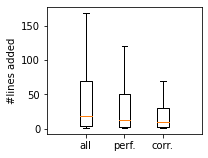

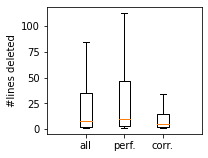

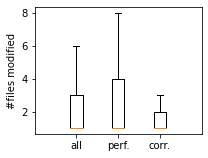

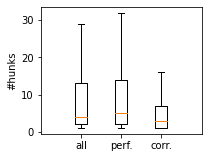

In [24]:
print_boxes_size(df, save=True, predictions=True)

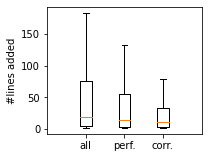

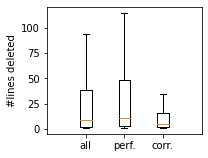

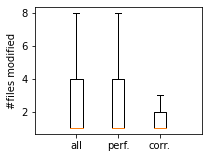

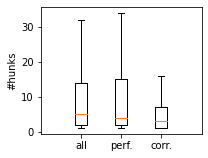

In [25]:
print_boxes_size(gt, save=True, predictions=False)

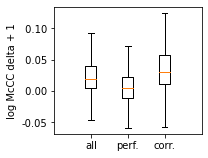

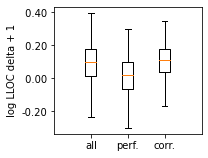

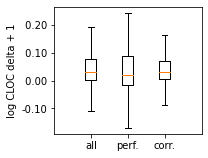

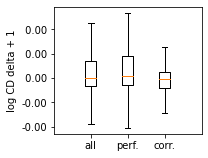

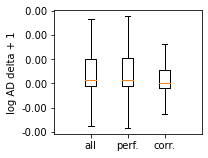

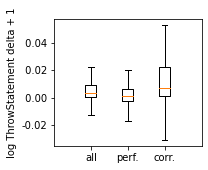

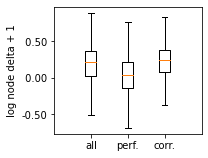

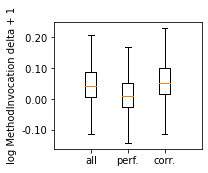

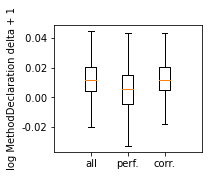

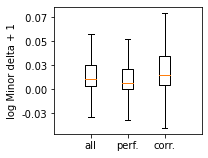

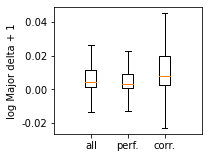

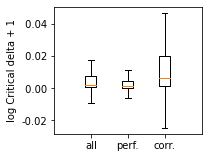

In [26]:
print_boxes_metrics(df, COLUMBUSQM_FEATURES, density=True, predictions=True, only_changes=False)

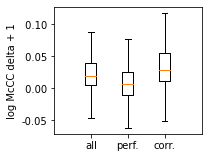

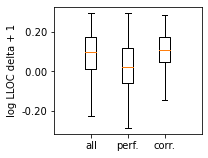

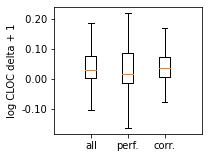

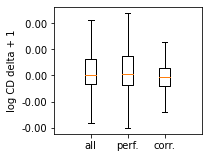

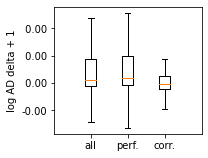

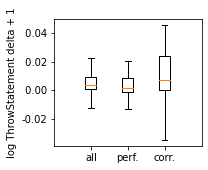

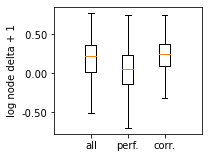

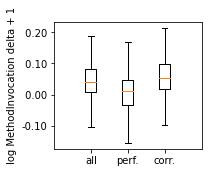

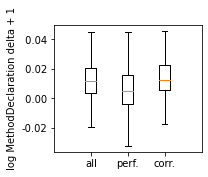

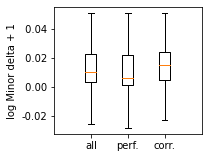

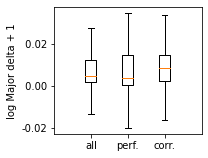

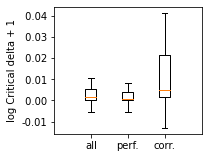

In [27]:
print_boxes_metrics(gt, COLUMBUSQM_FEATURES, density=True, predictions=False, only_changes=False)

McCC & 21.78 & 18.78 & 33.23\\
LLOC & 186.98 & 163.75 & 264.18\\
CLOC & 46.25 & 55.00 & 54.00\\
CD & 0.25 & 0.32 & 0.25\\
AD & 0.50 & 0.67 & 0.46\\
ThrowStatement & 2.00 & 1.72 & 2.67\\
node & 546.71 & 476.00 & 784.00\\
MethodInvocation & 62.00 & 50.00 & 96.00\\
MethodDeclaration & 13.00 & 12.00 & 17.00\\
Minor & 7.00 & 6.00 & 9.67\\
Major & 2.00 & 1.25 & 3.00\\
Critical & 0.00 & 0.00 & 0.00\\



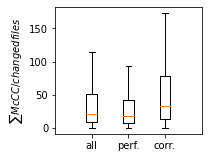

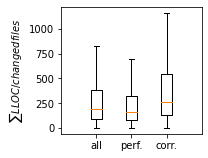

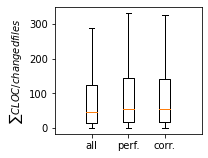

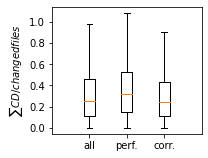

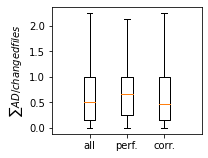

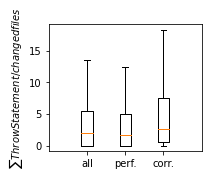

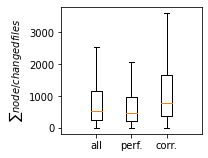

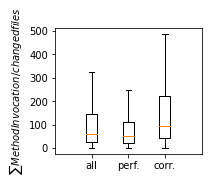

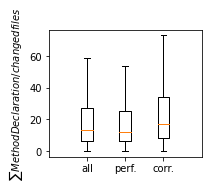

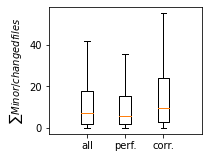

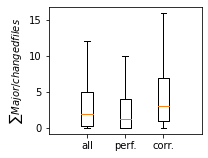

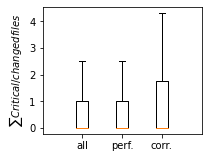

In [28]:
parent_files(df, COLUMBUSQM_FEATURES, save=True, predictions=True)

McCC & 21.00 & 18.00 & 34.00\\
LLOC & 187.22 & 160.38 & 270.00\\
CLOC & 48.22 & 55.00 & 55.00\\
CD & 0.25 & 0.31 & 0.24\\
AD & 0.50 & 0.63 & 0.49\\
ThrowStatement & 2.00 & 1.49 & 2.00\\
node & 539.00 & 457.42 & 810.00\\
MethodInvocation & 63.00 & 48.83 & 98.00\\
MethodDeclaration & 13.00 & 11.59 & 16.50\\
Minor & 7.00 & 5.43 & 10.00\\
Major & 2.00 & 1.00 & 2.67\\
Critical & 0.00 & 0.00 & 0.00\\



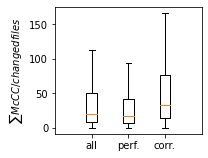

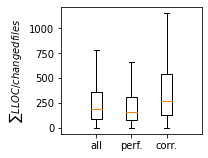

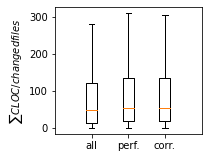

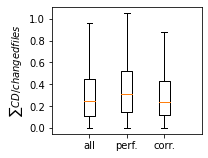

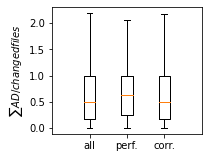

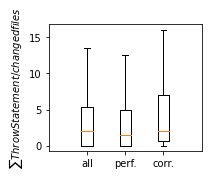

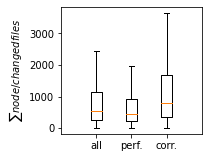

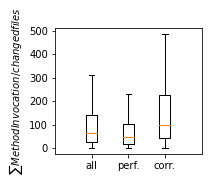

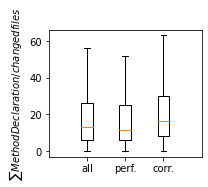

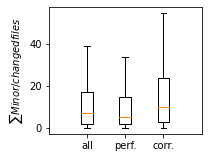

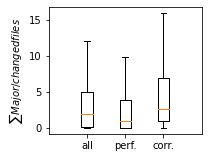

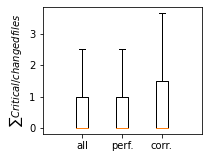

In [29]:
parent_files(gt, COLUMBUSQM_FEATURES, save=True, predictions=False)

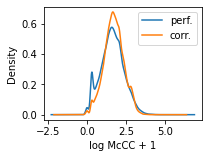

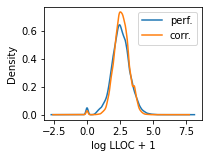

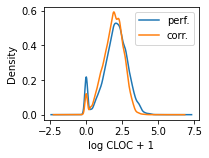

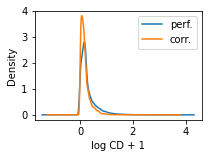

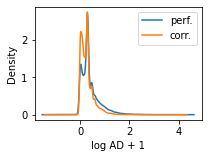

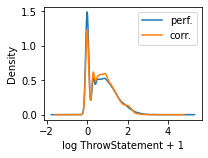

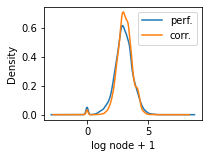

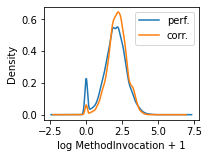

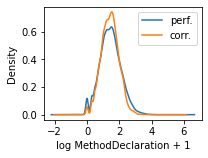

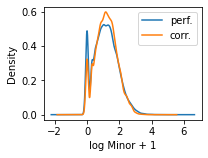

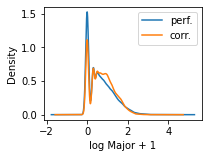

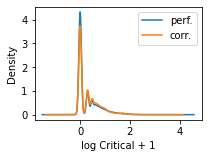

In [30]:
plot_parent_density(df, COLUMBUSQM_FEATURES)

In [31]:
print_detailed_tables_parents(df, COLUMBUSQM_FEATURES, thresh=THRESH)

Perfective
Metric & p-val & d & MWU Statistic & \Median & \#Samples & Non-normality\
McCC & \textbf{\textless0.0001} & 0.05 (n) & 1946723702.0 & 47.00,39.00 & 77630,47852 & True,True\\
LLOC & \textbf{\textless0.0001} & 0.05 (n) & 1946637361.5 & 397.00,335.00 & 77630,47852 & True,True\\
CLOC & \textbf{\textless0.0001} & 0.12 (s) & 1642584608.5 & 84.00,118.00 & 77630,47852 & True,True\\
CD & \textbf{\textless0.0001} & 0.15 (s) & 1570226793.0 & 0.40,0.54 & 77630,47852 & True,True\\
AD & \textbf{\textless0.0001} & 0.17 (s) & 1548982847.0 & 0.83,1.00 & 77630,47852 & True,True\\
ThrowStatement & \textbf{\textless0.0001} & 0.02 (n) & 1888932172.5 & 4.00,4.00 & 77630,47852 & True,True\\
node & \textbf{\textless0.0001} & 0.05 (n) & 1954322438.0 & 1161.00,967.00 & 77630,47852 & True,True\\
MethodInvocation & \textbf{\textless0.0001} & 0.09 (n) & 2033588413.5 & 141.00,102.00 & 77630,47852 & True,True\\
MethodDeclaration & 0.0121 & - & 1841746664.5 & 26.00,26.00 & 77630,47852 & True,True\\
Minor &

In [32]:
print_detailed_tables_parents(df, COLUMBUSQM_FEATURES, thresh=THRESH, normality='shapiro')

C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-va

Perfective
Metric & p-val & d & MWU Statistic & \Median & \#Samples & SHA Statistic & SHA p-val\
McCC & \textbf{\textless0.0001} & 0.05 (n) & 1946723702.0 & 47.00,39.00 & 77630,47852 & 0.27,0.21 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
LLOC & \textbf{\textless0.0001} & 0.05 (n) & 1946637361.5 & 397.00,335.00 & 77630,47852 & 0.26,0.21 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
CLOC & \textbf{\textless0.0001} & 0.12 (s) & 1642584608.5 & 84.00,118.00 & 77630,47852 & 0.18,0.24 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
CD & \textbf{\textless0.0001} & 0.15 (s) & 1570226793.0 & 0.40,0.54 & 77630,47852 & 0.08,0.14 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
AD & \textbf{\textless0.0001} & 0.17 (s) & 1548982847.0 & 0.83,1.00 & 77630,47852 & 0.11,0.14 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
ThrowStatement & \textbf{\textless0.0001} & 0.02 (n) & 1888932172.5 & 4.00,4.00 & 77630,47852 & 0.30,0.23 & \textbf{\textless0.0001},\textbf{\textle

In [33]:
print_detailed_tables_metrics(df, COLUMBUSQM_FEATURES, density=True, thresh=THRESH)

Perfective
Metric & p-val & d & MWU Statistic & \Median & \#Samples & Non-normality\
McCC & \textbf{\textless0.0001} & 0.39 (m) & 2579401012.5 & 0.02,0.00 & 77630,47852 & True,True\\
LLOC & \textbf{\textless0.0001} & 0.45 (m) & 2691844899.5 & 0.25,0.00 & 77630,47852 & True,True\\
CLOC & \textbf{\textless0.0001} & 0.16 (s) & 2158356261.5 & 0.00,0.00 & 77630,47852 & True,True\\
CD & 1.0000 & - & 1715608163.5 & 0.00,0.00 & 77630,47852 & True,True\\
AD & \textbf{\textless0.0001} & 0.02 (n) & 1899339427.0 & 0.00,0.00 & 77630,47852 & True,True\\
ThrowStatement & \textbf{\textless0.0001} & 0.11 (s) & 2053320645.5 & 0.00,0.00 & 77630,47852 & True,True\\
node & \textbf{\textless0.0001} & 0.47 (m) & 2733564438.5 & 0.75,0.00 & 77630,47852 & True,True\\
MethodInvocation & \textbf{\textless0.0001} & 0.40 (m) & 2598590345.5 & 0.07,0.00 & 77630,47852 & True,True\\
MethodDeclaration & \textbf{\textless0.0001} & 0.27 (s) & 2351989849.5 & 0.00,0.00 & 77630,47852 & True,True\\
Minor & \textbf{\textless0.

In [34]:
print_detailed_tables_metrics(df, COLUMBUSQM_FEATURES, density=True, thresh=THRESH, normality='shapiro')

C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
C:\Users\myxna\AppData\Roaming\Python\Python38\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-va

Perfective
Metric & p-val & d & MWU Statistic & \Median & \#Samples & SHA Statistic & SHA p-val\
McCC & \textbf{\textless0.0001} & 0.39 (m) & 2579401012.5 & 0.02,0.00 & 77630,47852 & 0.55,0.27 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
LLOC & \textbf{\textless0.0001} & 0.45 (m) & 2691844899.5 & 0.25,0.00 & 77630,47852 & 0.57,0.20 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
CLOC & \textbf{\textless0.0001} & 0.16 (s) & 2158356261.5 & 0.00,0.00 & 77630,47852 & 0.32,0.34 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
CD & 1.0000 & - & 1715608163.5 & 0.00,0.00 & 77630,47852 & 0.41,0.21 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
AD & \textbf{\textless0.0001} & 0.02 (n) & 1899339427.0 & 0.00,0.00 & 77630,47852 & 0.25,0.13 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
ThrowStatement & \textbf{\textless0.0001} & 0.11 (s) & 2053320645.5 & 0.00,0.00 & 77630,47852 & 0.05,0.01 & \textbf{\textless0.0001},\textbf{\textless0.0001}\\
node & \textbf{\textle